## Importing Libraries

In [1]:
import requests
import zipfile
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

In [2]:
from pathlib import Path
import requests, zipfile, os

folder = Path('resources')
image_path = folder / 'data'

if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download the file
    url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip"
    response = requests.get(url)

    zip_file_path = image_path / 'concrete_crack_images_for_classification.zip'
    with open(zip_file_path, 'wb') as f:
        print("Downloading the file")
        f.write(response.content)

    # Confirm download
    print(f"Downloaded size: {zip_file_path.stat().st_size / 1024:.2f} KB")

    # Unzip it
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print("Unzipping the file")
        zip_ref.extractall(image_path)

    os.remove(zip_file_path)


resources/data already exists


In [3]:
for dir_paths, dir_files, file_names in os.walk(image_path):
    print(f" There are {len(dir_files)} directories and {len(file_names)} images in {dir_paths}")

 There are 2 directories and 1 images in resources/data
 There are 0 directories and 20000 images in resources/data/Positive
 There are 0 directories and 20000 images in resources/data/Negative


Positive folder contains images which doesn't have any kinds of cracks and negative has the vice versa files. 

In [4]:
crack_positive_path = image_path/'positive'
crack_negative_path = image_path/'negative'

In [5]:
crack_negative_path,crack_positive_path

(PosixPath('resources/data/negative'), PosixPath('resources/data/positive'))

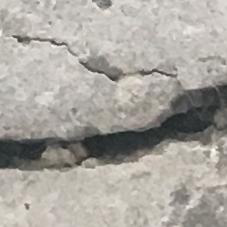

In [6]:
# Plot some random images from positive folders
import random
positive_image_list = list(Path(crack_positive_path).glob('*.jpg'))

rand_postive_img = random.choice(positive_image_list)

img = Image.open(rand_postive_img)

Path(rand_postive_img).parent.stem
img

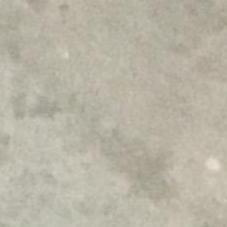

In [7]:
# Plot some random image from negative folders

negative_image_list = list(Path(crack_negative_path).glob('*.jpg'))

rand_negative_img = random.choice(negative_image_list)

img = Image.open(rand_negative_img)

img


<Figure size 3000x1500 with 0 Axes>

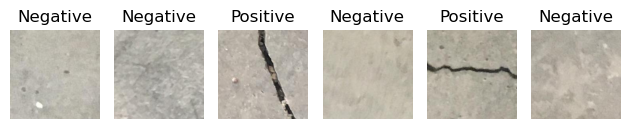

In [8]:
# Plot images with matplotlib
import numpy as np
image_list = list(Path(image_path).glob('*/*.jpg'))

rand_imgs = random.sample(image_list,k = 6)

plt.figure(figsize = (30,15))
plt.subplots(nrows = 1, ncols = 6)
for idx,img in enumerate(rand_imgs):
    
    # set the subplot
    plt.subplot(1,6,idx+1)
    # convert the image into numpy
    np_img = np.asarray(Image.open(img))
    plt.imshow(np_img)
    plt.title(f"{Path(img).parent.stem}")
    plt.axis(False)
    plt.tight_layout()
    
    

In [9]:
len(image_list)

40000

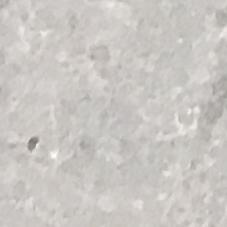

In [10]:
Image.open(image_list[20000])

In [11]:
from torch.utils.data import DataLoader,Dataset

In [12]:
from torchvision import datasets,transforms

In [13]:
# Create transformation funciton
transform_data = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [14]:
train_data = datasets.ImageFolder(image_path,
                                 transform = transform_data
                                 )

In [15]:
class_names = train_data.classes

In [16]:
train_data.class_to_idx

{'Negative': 0, 'Positive': 1}

In [17]:
img,label = train_data[20000]
img.shape,label

(torch.Size([3, 64, 64]), 1)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

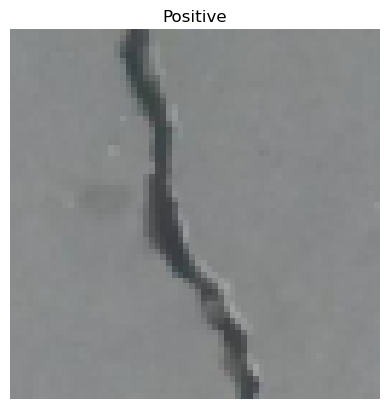

In [18]:
# Plot a random image from the train data
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [19]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [20]:
shuffled_dataset = list(train_data)

random.shuffle(shuffled_dataset)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

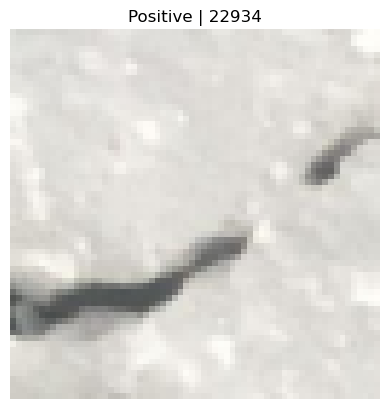

In [21]:
# Plot a random image from the train data
idx = random.randint(0,len(shuffled_dataset))
img,label = shuffled_dataset[idx]
plt.imshow(img.permute(1,2,0))
plt.title(f"{class_names[label]} | {idx}")
plt.axis(False)

## Custom Dataset

In [22]:
from torchvision import datasets


In [23]:
def find_classes(img_dir):
    classes = sorted(entry.name for entry in os.scandir(img_dir) if entry.is_dir())

    class_to_idx = {class_name: i for i,class_name in enumerate(classes)}

    return classes,class_to_idx
    

In [24]:
import pathlib
from pathlib import Path

In [25]:
class CustomDataset(Dataset):

    def __init__(self,
                 all_images:dir,
                 transform:torchvision.transforms = None):

        # I got the full sorted path, have to create a list, shuffling that
        self.all_images = all_images # directory path of all files
        self.images_list  = list(pathlib.Path(self.all_images).glob("*/*.jpg")) # convert the directory path into a list
        random.shuffle(self.images_list) # shuffle the list
        self.transform = transform
        self.classes,self.class_to_idx = find_classes(self.all_images)


    def load_img(self,idx):
        img = Image.open(self.images_list[idx])
        return img

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self,idx):
        img = self.load_img(idx)
        class_name = self.images_list[idx].parent.name
        class_to_idx = self.class_to_idx[class_name]
        
        if self.transform:
            img = self.transform(img)

        return img,class_to_idx
        
        

In [26]:
image_path

PosixPath('resources/data')

In [49]:
custom_data = CustomDataset(image_path)

In [28]:
custom_data.classes

['Negative', 'Positive']

In [29]:
custom_data.class_to_idx

{'Negative': 0, 'Positive': 1}

(np.float64(-0.5), np.float64(226.5), np.float64(226.5), np.float64(-0.5))

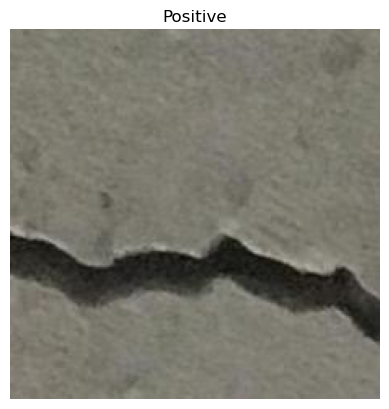

In [51]:
img,label = custom_data[710]
plt.imshow(img)
plt.title(class_names[label])
plt.axis(False)

In [54]:
print(img.size)

(227, 227)


## Split into Train and Validation Dataset

In [56]:
from torch.utils.data import random_split
total_size = len(custom_data)

train_size = 30000
val_size = total_size-train_size

train_dataset,val_set = random_split(custom_data,[train_size,val_size])

In [59]:
len(train_dataset),len(val_set)

(30000, 10000)

In [63]:
train_dataset.dataset.classes

['Negative', 'Positive']

## Final Dataset Creation Class (If download foleder has a specific method)

download_folder -->
                    Class_Name
                    

In [26]:
def find_classes(class_dir):
    """ Should create separate two classes,
    each class for one specific category"""
    classes = sorted(entry.name for entry in os.scandir(class_dir) if entry.is_dir())
    class_to_idx = {class_name:i for i,class_name in enumerate(classes)}
    return classes,class_to_idx
    

In [27]:
pathlib.Path(image_path)

PosixPath('resources/data')

In [43]:
from torch.utils.data import Dataset
class CustomDataset2(Dataset):
    """ Takes the download directory and converts it into train and validation separate datasets
    """
    def __init__(self,img_dir:dir,
                 transform  = None,
                 train = None, # if train is true it delivers the train dataset otherwise validation dataset,
                ):
        
        self.image_list = list(pathlib.Path(img_dir).glob('*/*.jpg'))
        random.shuffle(self.image_list)
        if train:
            self.image_list = self.image_list[:30000]
        else:
            self.image_list = self.image_list[30000:]
        self.transform  = transform 
        self.classes,self.class_to_idx = find_classes(img_dir)

    def __len__(self):
        return len(self.image_list)

    def load_img(self,idx):
        img = Image.open(self.image_list[idx])
        return img

    def __getitem__(self,idx):
        
        img = self.load_img(idx)
        class_name = self.image_list[idx].parent.name
        class_to_idx = self.class_to_idx[class_name]

        if self.transform:
            img = self.transform(img)

        return img, class_to_idx
        


    

In [44]:
image_path

PosixPath('resources/data')

In [45]:
cd2 = CustomDataset2(img_dir=image_path,
                     transform=None,
                     train=True)

In [46]:
cd2.classes

['Negative', 'Positive']

In [47]:
cd2.class_to_idx

{'Negative': 0, 'Positive': 1}

In [48]:
len(cd2)

30000

(np.float64(-0.5), np.float64(226.5), np.float64(226.5), np.float64(-0.5))

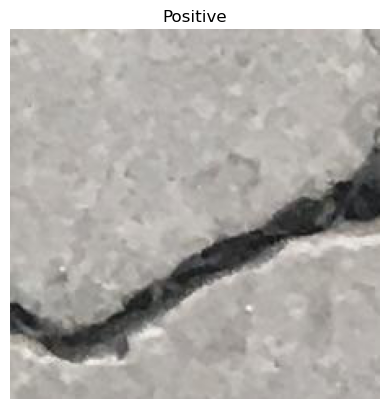

In [57]:
# Plot some random image
import random 
idx = random.randint(0,len(cd2))
img,idx = cd2[idx]

plt.imshow(img)
plt.title(class_names[idx])
plt.axis(False)

In [58]:
val_dataset = CustomDataset2(img_dir = image_path,
                             transform = None,
                             train = False)

In [59]:
len(val_dataset)

10000

(np.float64(-0.5), np.float64(226.5), np.float64(226.5), np.float64(-0.5))

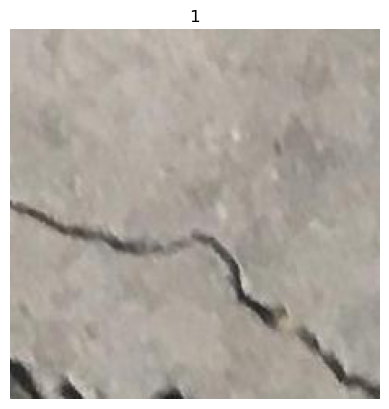

In [78]:
# Plot some random image
import random 
idx = random.randint(0,len(val_dataset))
img,idx = val_dataset[idx]

plt.imshow(img)
plt.title(idx)
plt.axis(False)

## Final Dataset Class if Dataset doesn't have a specific orientation

In [115]:
class CustomDatasetWithOutSpecificOrientation(Dataset):

    def __init__(self,
                 img_dir: dir,
                 transform: torchvision.transforms = None,
                 train = None):

        
        positive_img = img_dir/'positive'
        negative_img = img_dir/'negative'
        self.img_list = [0]*len(list(pathlib.Path(img_dir).glob('*/*.jpg')))
        self.img_list[0::2] = pathlib.Path(negative_img).glob('*.jpg')
        self.img_list[1::2] = pathlib.Path(positive_img).glob('*.jpg')
        
        self.Y = torch.zeros(len(self.img_list))
        self.Y[1::2] = 1
        self.transform = transform 

        if train:
            self.img_list[:30000]
        else:
            self.img_list[30000:]



    def __len__(self):
        return len(self.img_list)

    def load_img(self,idx):
        img = Image.open(self.img_list[idx])
        return img

    def __getitem__(self,idx):

        img = torch.tensor(np.asarray(self.load_img(idx)),dtype = torch.float32)
        class_label = self.Y[idx]
        if self.transform:
            img = self.load_img[idx]

        return img, class_label        
        

In [116]:
train_data = CustomDatasetWithOutSpecificOrientation(img_dir=image_path,
                                                         transform=None,
                                                         train = True)

val_data = CustomDatasetWithOutSpecificOrientation(img_dir=image_path,
                                                         transform=None,
                                                         train = False)


In [117]:
train_data[5]

(tensor([[[166., 154., 140.],
          [165., 153., 139.],
          [166., 154., 140.],
          ...,
          [180., 168., 154.],
          [179., 167., 153.],
          [177., 165., 151.]],
 
         [[167., 155., 141.],
          [166., 154., 140.],
          [165., 153., 139.],
          ...,
          [179., 167., 153.],
          [178., 166., 152.],
          [177., 165., 151.]],
 
         [[169., 157., 143.],
          [167., 155., 141.],
          [165., 153., 139.],
          ...,
          [176., 164., 150.],
          [176., 164., 150.],
          [175., 163., 149.]],
 
         ...,
 
         [[174., 161., 145.],
          [171., 159., 143.],
          [168., 156., 140.],
          ...,
          [203., 191., 175.],
          [193., 181., 165.],
          [186., 174., 158.]],
 
         [[174., 161., 145.],
          [171., 159., 143.],
          [168., 156., 140.],
          ...,
          [209., 197., 181.],
          [200., 188., 172.],
          [193., 181., 165.

Text(0.5, 1.0, 'tensor(1.)')

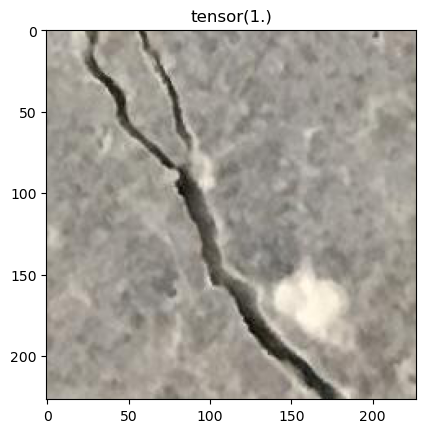

In [108]:
idx = random.randint(0,len(train_data))
img,label = train_data[idx]
plt.imshow(img)
plt.title(label)

## DataLoader

In [118]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

val_dataloader = DataLoader(dataset = val_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False)


In [122]:
img_label   = next(iter(train_dataloader))

len(img_label)

2